In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import KFold

In [25]:
import glob
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling1D,Concatenate,Conv2D,Conv1D,AveragePooling2D,GlobalAveragePooling1D, MaxPooling2D, Flatten, Dense,BatchNormalization,Add,Input,Activation

**Import Data**


In [26]:
import glob
import librosa
import numpy as np

data1 = []
labels1 = []

aoritcstenosis = glob.glob('/kaggle/input/15sdataforheartsound/aorticstenosis/*.wav')
mit_regurg = glob.glob('/kaggle/input/15sdataforheartsound/mitral regurgitation/*.wav')
mit_steno = glob.glob('/kaggle/input/15sdataforheartsound/mitral stenosis/*.wav')
mit_valve = glob.glob('/kaggle/input/15sdataforheartsound/mitral valve prolapse/*.wav')
normal = glob.glob('/kaggle/input/15sdataforheartsound/normal/*.wav')


SAMPLE_RATE=2000

nsample=2250
for file_path in aoritcstenosis:   
    #print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    signal=np.array(signal[0:nsample])
#     print(signal.shape)
    data1.append(signal)
    labels1.append(0)

for file_path in mit_regurg:   
   # print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    signal=np.array(signal[0:nsample])
#     print(signal.shape)
    data1.append(signal)
    labels1.append(1)
for file_path in mit_steno:   
    #print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

    signal=np.array(signal[0:nsample])
#     print(signal.shape)
    data1.append(signal)
    labels1.append(2)

for file_path in mit_valve:   
   # print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

    
    signal=np.array(signal[0:nsample])
#     print(signal.shape)
    data1.append(signal)
    labels1.append(3)
for file_path in normal:   
    #print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    
    signal=np.array(signal[0:nsample])
    if signal.shape==(nsample,):
#     print(signal.shape)
        data1.append(signal)
        labels1.append(4)
    else:
        continue
X_train= np.array(data1)
y_train= np.array(labels1)

In [27]:
print(X_train.shape)

print(y_train.shape)

(1000, 2250)
(1000,)


**WaveNet Model**

In [28]:
n_filters = 64
dilation_depth = 8
activation = 'softmax'
kernel_size = 2
traget=5
input_shape=(2250,1)

In [29]:
from keras.layers import BatchNormalization,Flatten,Conv1D, Input, Activation, AveragePooling1D, Add, Multiply, GlobalAveragePooling1D
from keras.models import Model
def residual_block(x, i):
    tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal',
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      activation='sigmoid'
                      )(x)
    z = Multiply()([tanh_out, sigm_out])
    skip = Conv1D(n_filters, 1)(z)
    res = Add()([skip, x])
    return res, skip


In [30]:
inputs = Input(shape=input_shape)
skip_connections = []
out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal')(inputs)
for i in range(1, dilation_depth + 1):
    out, skip = residual_block(out,i)
    skip_connections.append(skip)
out = Add()(skip_connections)
out = Activation('relu')(out)

out=Flatten()(out)

In [31]:
out.shape

TensorShape([None, 144000])

**ResNet**

In [32]:
def id_block(x,filter_number):
    

    #Saving the input for add()
    res_x=x

    #Layer 1
    x = Conv1D(filter_number, 3, padding ='same', activation='relu')(x)

    #Layer 2
    x = Conv1D(filter_number, 3,padding='same')(x)

    #Add residue
    x = Add()([x, res_x])
    x = Activation('relu')(x)

    return x

In [33]:
def conv_block(x,filter_number):
    
    #Saving the input for add()
    res_x=x

    #Layer 1
    x = Conv1D(filter_number, 3, strides=2, padding ='same', activation='relu')(x) #strides added

    #Layer 2
    x = Conv1D(filter_number,3,padding='same')(x)

    #residue passed through conv 1x1 before add()
    res_x= Conv1D(filter_number,1, strides = 2)(res_x)

    #Add residue
    x = Add()([x, res_x])
    x = Activation('relu')(x)

    return x

In [34]:
def ResNet34(x):
    #Step_1 Initial conv layer with MaxPool
    x = Conv1D(64,7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    #Step_2 Define block bundle sizes
    block_size = [3,4,6,3]
    filter_number= 64

    #Step_3 Block in loops

    for i in range(4):

        if i==0:
            #No conv block in this bundle
            for j in range(block_size[i]):
                x=id_block(x,filter_number)
        else: #The first block is conv block, the rest in identity blocks and filter number increases 2x in each iteration
            filter_number = filter_number*2
            x = conv_block(x, filter_number)

            for j in range(block_size[i] - 1):
                x = id_block(x, filter_number)

    #Step_4 Add dense layers

    # Average Pooling
    x = AveragePooling1D(2,padding='same')(x)

    # Flatten the feature maps
    x = Flatten()(x)

    return x

In [35]:
out2=ResNet34(inputs)

In [36]:
out2

<KerasTensor: shape=(None, 18432) dtype=float32 (created by layer 'flatten_3')>

**Concatenate the Feature Maps**

In [37]:
merged = Concatenate()([out, out2])

In [38]:
merged.shape

TensorShape([None, 162432])

**Classifier Layer**

In [39]:
merged = Dense(512, activation='relu')(merged)
merged = BatchNormalization()(merged)

# Add the output layer with the desired number of units and activation function
outputs = Dense(5, activation='softmax')(merged)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2250, 1)]    0           []                               
                                                                                                  
 conv1d_86 (Conv1D)             (None, 1125, 64)     512         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 1125, 64)    256         ['conv1d_86[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_19 (Activation)     (None, 1125, 64)     0           ['batch_normalization_2[0][

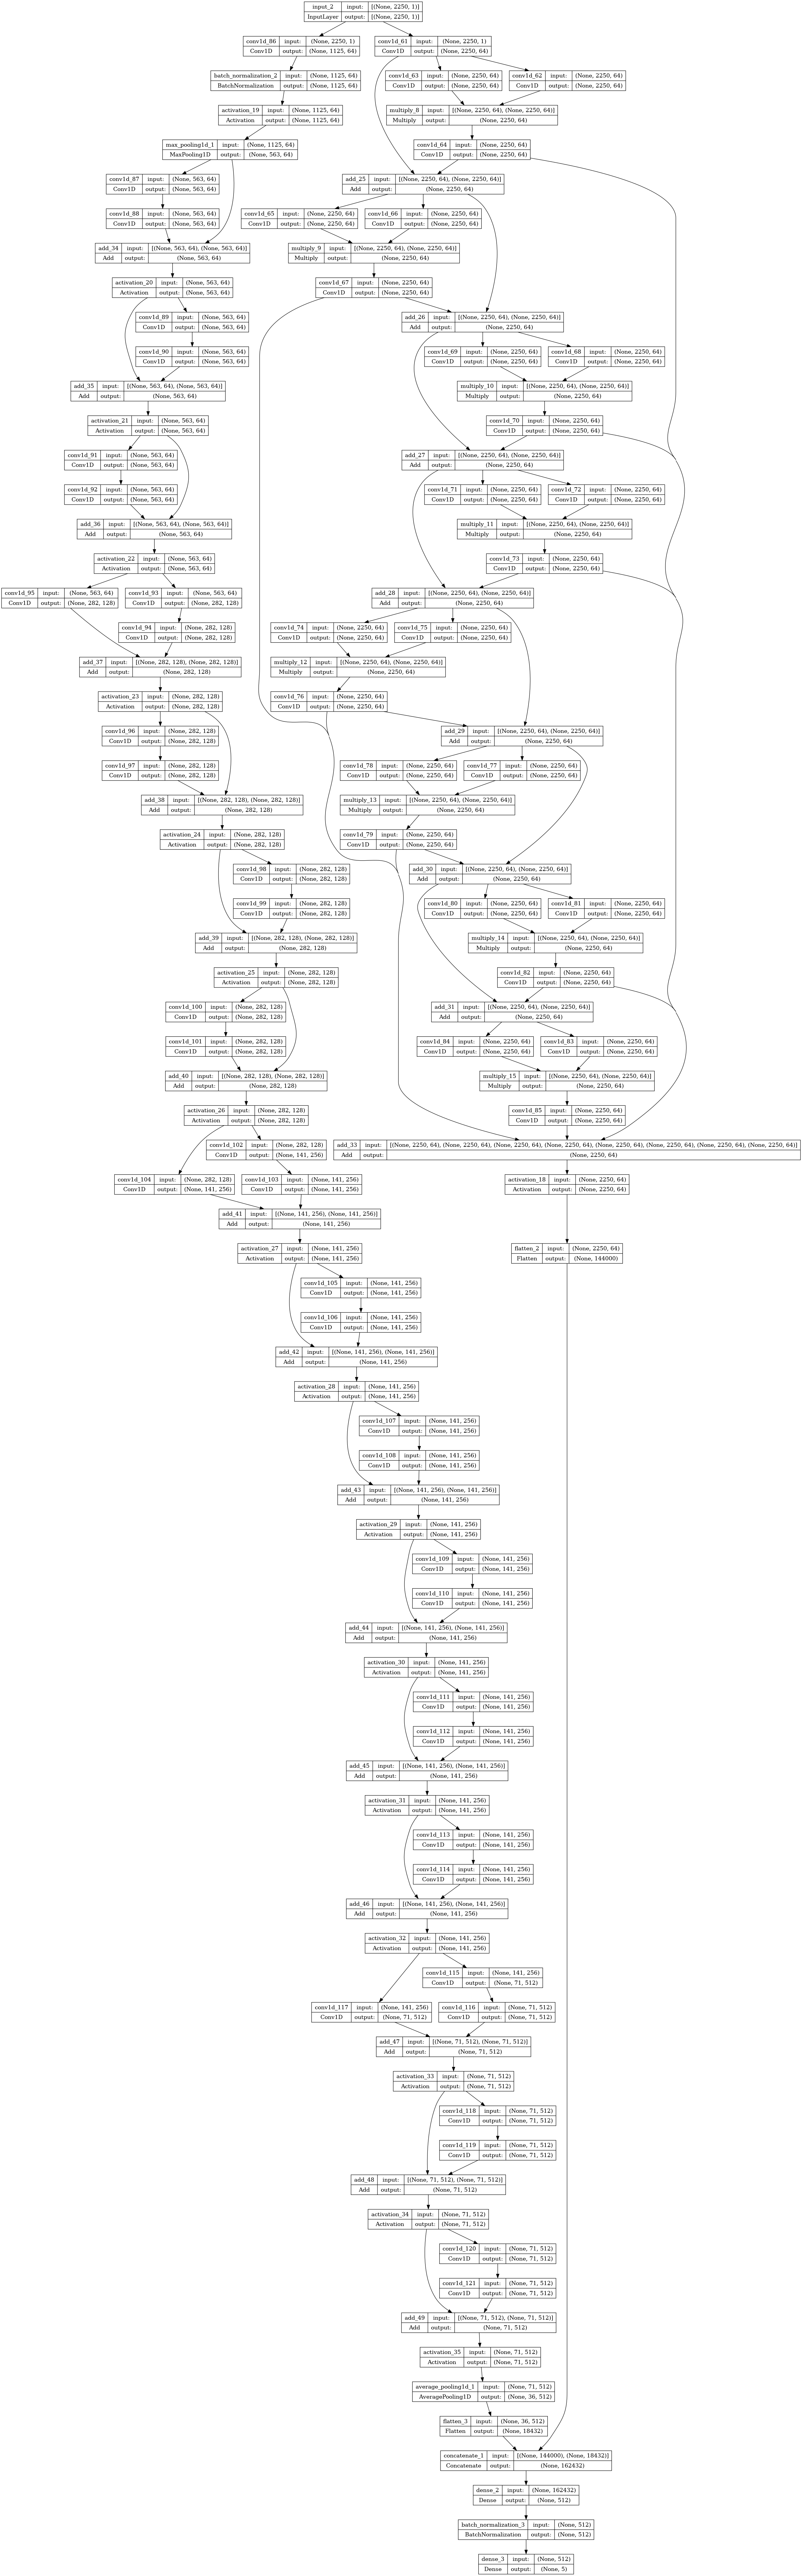

In [41]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [42]:
model.compile(optimizer='adam', 
                          loss='sparse_categorical_crossentropy', 
                          metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)


In [43]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, y_train):

  # Generate a print
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X_train[train], y_train[train],
              batch_size=32,
              epochs=10,
              verbose=1,callbacks=[checkpoint_callback,early_stopping_callback])

  # Generate generalization metrics
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Training for fold 1 ...
Epoch 1/10
29/29 [==============================] - 28s 102ms/step - loss: 0.5575 - accuracy: 0.8078
Epoch 2/10
29/29 [==============================] - 3s 102ms/step - loss: 0.2799 - accuracy: 0.8944
Epoch 3/10
29/29 [==============================] - 3s 102ms/step - loss: 0.2085 - accuracy: 0.9356
Epoch 4/10
29/29 [==============================] - 3s 104ms/step - loss: 0.2128 - accuracy: 0.9356
Epoch 5/10
29/29 [==============================] - 3s 102ms/step - loss: 0.1924 - accuracy: 0.9256
Epoch 6/10
29/29 [==============================] - 3s 102ms/step - loss: 0.1380 - accuracy: 0.9600
Epoch 7/10
29/29 [==============================] - 3s 102ms/step - loss: 0.1172 - accuracy: 0.9611
Epoch 8/10
29/29 [==============================] - 3s 102ms/step - loss: 0.1196 - accuracy: 0.9578
Epoch 9/10
29/29 [==============================] - 3s 102ms/step - loss: 0.1069 - accuracy: 0.9700
Epoch 10/10
29/29 [==============================] - 3s 102ms/step - loss: 